In [1]:
from datetime import datetime
import numpy as np
import pandas as pd
from lightning import seed_everything
from seisLM.data_pipeline import foreshock_aftershock_dataset as myu
from seisLM.data_pipeline import ref_foreshock_aftershock_dataset as u
from seisLM.utils.project_path import DATA_DIR

dataToProcess = "NRCA"
seed = 42
# path = '/scicore/home/dokman0000/liu0003/projects/seisLM/data/wetransfer_classify_generic_norcia-py_2024-06-24_1530/'
path = f'{DATA_DIR}/foreshock_aftershock_NRCA/'

num_classes = 4

train_percentage = 0.7
val_percentage = 0.10
test_percentatge = 0.20


force_traces_in_test=[]
seed_everything(seed)
df_empty = pd.DataFrame(columns = [
    'E_channel', 'N_channel', 'Z_channel', 'trace_name', 'label',
    'trace_start_time', 'network_code', 'receiver_name', 'receiver_type',
    'receiver_elevation_m', 'receiver_latitude', 'receiver_longitude',
    'source_id', 'source_depth_km', 'source_latitude', 'source_longitude',
    'source_magnitude_type', 'source_magnitude', 'source_origin_time',
    'p_travel_sec']
)
df_pre = df_empty.copy()
df_visso = df_empty.copy() # if num_classes!=9 this df will remain empty
df_post = df_empty.copy()

df_pre = pd.read_pickle(path+'dataframe_pre_'+dataToProcess+'.csv')
df_post = pd.read_pickle(path+'dataframe_post_'+dataToProcess+'.csv')
if num_classes==9:
  df_visso = pd.read_pickle(path+'dataframe_visso_'+dataToProcess+'.csv')

df_pre, df_visso, df_post=u.pre_post_equal_length(
  df_pre, df_visso, df_post,force_traces_in_test, num_classes)

for i in force_traces_in_test:
  if (i not in df_pre['trace_name'].values) and (
    i not in df_visso['trace_name'].values) and (
      i not in df_post['trace_name'].values):
    print("WARNING: ", i,
          " not in df_pre and df_post. This will cause an error.")

df_pre['trace_start_time'] = df_pre['trace_start_time'].apply(
  lambda x: datetime.strptime(x, '%Y-%m-%dT%H:%M:%S.%fZ'))
df_visso['trace_start_time'] = df_visso['trace_start_time'].apply(
  lambda x: datetime.strptime(x, '%Y-%m-%dT%H:%M:%S.%fZ'))
df_post['trace_start_time'] = df_post['trace_start_time'].apply(
  lambda x: datetime.strptime(x, '%Y-%m-%dT%H:%M:%S.%fZ'))


if num_classes==2:
  df=pd.concat([df_pre, df_post], ignore_index=True)
else:
  frames_pre = u.frames_N_classes(df_pre,num_classes, pre_or_post="pre")
  frames_post = u.frames_N_classes(df_post,num_classes, pre_or_post="post")
  if num_classes==9:
    frames_visso = u.frames_N_classes(
      df_visso,num_classes, pre_or_post="visso"
    )
    df=pd.concat(
      [pd.concat(frames_pre),
        pd.concat(frames_visso),
        pd.concat(frames_post)],
      ignore_index=True
    )
  else:
    df = pd.concat(
      [pd.concat(frames_pre),pd.concat(frames_post)], ignore_index=True
    )

df['source_origin_time'] = df['source_origin_time'].apply(
  lambda x: datetime.strptime(x, '%Y-%m-%dT%H:%M:%S'))
df['TTF'] = df.apply (lambda row: u.add_TTF_in_sec(row), axis=1)


(df, X_train, y_train, index_train, X_val, y_val, index_val, X_test, y_test, index_test
  ) = u.train_val_test_split(
  df.copy(),
  split_random=False#True,
)

Seed set to 42


Setting seeds
0 [100588915, 100589402, 100589658, 100589840, 100589896, 100589906, 100589945, 100589974, 100589984, 100590034, 100590044, 100590046, 100590229, 100590247, 100590254, 100590274, 100590297, 100590363, 100590430, 100590512, 100590515, 100590624, 100590711, 100590758, 100590795, 100590836, 100590841, 100590850, 100590922, 100590969, 100590986, 100591053, 100591054, 100591162, 100591834, 100591837, 100591855, 100591863, 100591891, 100591923, 100591955, 100591957, 100591961, 100591979, 100592021, 100592024, 100592029, 100592039, 100592061, 100592067, 100592088, 100592126, 100592144, 100592157, 100592161, 100592169, 100592172, 100592214, 100592217, 100592277, 100592281, 100592304, 100592307, 100592309, 100592407, 100592414, 100592423, 100592479, 100592483, 100592488, 100592524, 100592663, 100592691, 100592726, 100592757, 100592767, 100592878, 100592948, 100592986, 100593025, 100593040, 100593122, 100593141, 100593156, 100593192, 100593212, 100593219, 100593302, 100593394, 1005

In [2]:
# df['source_origin_time']


train_occurence_time = df['source_origin_time'].to_list()[index_train[0][0]:index_train[-1][0]+1]
val_occurence_time = df['source_origin_time'].to_list()[index_val[0][0]:index_val[-1][0]+1]
test_occurence_time = df['source_origin_time'].to_list()[index_test[0][0]:index_test[-1][0]+1]

# df['source_origin_time'][index_test[0][0]:index_test[-1][0]+1]



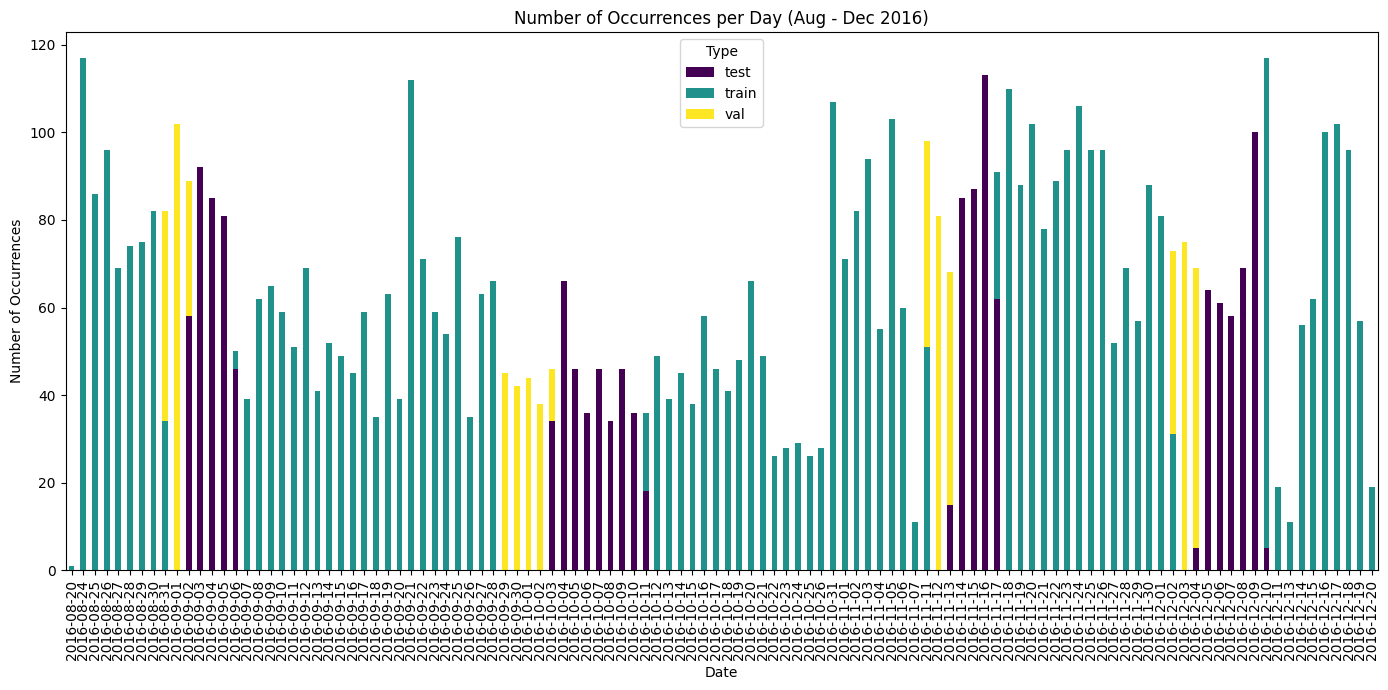

In [3]:
import matplotlib.pyplot as plt


# Combine all timestamps into a DataFrame
train_df = pd.DataFrame(train_occurence_time, columns=['timestamp'])
train_df['type'] = 'train'
val_df = pd.DataFrame(val_occurence_time, columns=['timestamp'])
val_df['type'] = 'val'
test_df = pd.DataFrame(test_occurence_time, columns=['timestamp'])
test_df['type'] = 'test'

# Concatenate all data
df = pd.concat([train_df, val_df, test_df])

# Extract the date part and count occurrences
df['date'] = df['timestamp'].dt.date
occurrences = df.groupby(['date', 'type']).size().unstack(fill_value=0)

# Plotting
occurrences.plot(kind='bar', stacked=True, figsize=(14, 7), colormap='viridis')
plt.xlabel('Date')
plt.ylabel('Number of Occurrences')
plt.title('Number of Occurrences per Day (Aug - Dec 2016)')
plt.legend(title='Type')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [4]:
# index_test[0][0]